### Import all the Dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Import data into tensorflow dataset object

In [2]:
# Constants
IMAGE_SIZE = 224  # Replace with your desired image size
BATCH_SIZE = 32
DATASET_DIR = '/kaggle/input/tomatoleaf/Dataset3'  # Path to your dataset directory
CLASS_NAMES = os.listdir(DATASET_DIR)

# Prepare a list of all image paths and corresponding labels
image_paths = []
labels = []

for class_name in CLASS_NAMES:
    class_dir = os.path.join(DATASET_DIR, class_name)
    for img_name in os.listdir(class_dir):
        image_paths.append(os.path.join(class_dir, img_name))
        labels.append(class_name)

# Create a DataFrame
data = pd.DataFrame({'image_path': image_paths, 'label': labels})


In [3]:
# Split into train, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.1, stratify=data['label'], random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.125, stratify=train_data['label'], random_state=42)  # 0.25 x 0.8 = 0.2


In [4]:
# def sequence_data_generator(generator, sequence_length):
#     while True:
#         images, labels = next(generator)
#         batch_size = images.shape[0]
#         # Reshape to create sequences (assuming batch_size is divisible by sequence_length)
#         sequences = images.reshape(batch_size // sequence_length, sequence_length, 224, 224, 3)
#         yield sequences, labels[:batch_size // sequence_length]

In [5]:
# Data Augmentation and Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.1,
    height_shift_range=0.1, 
    shear_range=0.2, 
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

train_generator = train_datagen.flow_from_dataframe(
    train_data,
    x_col='image_path',
    y_col='label',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    val_data,
    x_col='image_path',
    y_col='label',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    test_data,
    x_col='image_path',
    y_col='label',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Important to maintain order for evaluation
)

Found 25618 validated image filenames belonging to 11 classes.
Found 3660 validated image filenames belonging to 11 classes.
Found 3254 validated image filenames belonging to 11 classes.


In [6]:
# Get class indices
class_indices = train_generator.class_indices

# Map class names to their image counts
class_counts_dict = train_data['label'].value_counts().to_dict()

# Create a list of counts in the order of train_generator.class_indices
ordered_counts = [(class_name, class_counts_dict.get(class_name, 0)) for class_name in class_indices.keys()]

# Convert to a DataFrame for better visualization
ordered_counts_df = pd.DataFrame(ordered_counts, columns=['Class Name', 'Image Count'])

# Print the ordered counts
print(ordered_counts_df)



                              Class Name  Image Count
0                         Bacterial_spot         2802
1                           Early_blight         2439
2                            Late_blight         3075
3                              Leaf_Mold         2751
4                     Septoria_leaf_spot         2857
5   Spider_mites Two-spotted_spider_mite         1718
6                            Target_Spot         1799
7          Tomato_Yellow_Leaf_Curl_Virus         1996
8                    Tomato_mosaic_virus         2155
9                                healthy         3037
10                        powdery_mildew          989


In [7]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

In [8]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=0)
]

## Building the Model

In [9]:
from tensorflow.keras.models import Model
from keras.layers import Dense
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2 

strategy=tf.distribute.MirroredStrategy()
with strategy.scope():
    
    model = Sequential()
    
    vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    for layer in vgg_base.layers[-20:]:
         layer.trainable = True
        
    # Add custom layers on top of the VGG16 base
    x = vgg_base.output
    x = tf.keras.layers.GlobalAveragePooling2D()(vgg_base.output)
    x = Dense(32, activation='relu')(x)  # Custom fully connected layer
    x = Dense(11, activation='softmax')(x)  # Output layer for 4 classes
        
    # Create the complete model
    model = Model(inputs=vgg_base.input, outputs=x)
            
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy','Precision','Recall'])
print(model.summary())


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │          16,4

 Total params: 14,731,467 (56.20 MB)

 Trainable params: 14,731,467 (56.20 MB)

 Non-trainable params: 0 (0.00 B)

None


In [10]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [11]:
history = model.fit(
    train_generator,
    batch_size=BATCH_SIZE ,
    # steps_per_epoch = steps_per_epoch,  # Total samples / batch_size
    validation_data=validation_generator,
    # validation_steps = validation_steps,
    epochs=30,
    callbacks = callbacks
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


801/801 ━━━━━━━━━━━━━━━━━━━━ 582s 693ms/step - Precision: 0.5910 - Recall: 0.0832 - accuracy: 0.2761 - loss: 1.9668 - val_Precision: 0.8788 - val_Recall: 0.6814 - val_accuracy: 0.7869 - val_loss: 0.6681 - learning_rate: 1.0000e-04
Epoch 2/30
801/801 ━━━━━━━━━━━━━━━━━━━━ 415s 514ms/step - Precision: 0.8351 - Recall: 0.6328 - accuracy: 0.7309 - loss: 0.8013 - val_Precision: 0.8982 - val_Recall: 0.7907 - val_accuracy: 0.8415 - val_loss: 0.4664 - learning_rate: 1.0000e-04
Epoch 3/30
801/801 ━━━━━━━━━━━━━━━━━━━━ 414s 512ms/step - Precision: 0.8907 - Recall: 0.7777 - accuracy: 0.8272 - loss: 0.5101 - val_Precision: 0.8873 - val_Recall: 0.8219 - val_accuracy: 0.8475 - val_loss: 0.4725 - learning_rate: 1.0000e-04
Epoch 4/30
801/801 ━━━━━━━━━━━━━━━━━━━━ 408s 505ms/step - Precision: 0.9071 - Recall: 0.8124 - accuracy: 0.8530 - loss: 0.4206 - val_Precision: 0.9317 - val_Recall: 0.8503 - val_accuracy: 0.8869 - val_loss: 0.3443 - learning_rate: 1.0000e-04
Epoch 5/30
801/801 ━━━━━━━━━━━━━━━━━━━━ 400

In [12]:
# Evaluate on train data
train_scores = model.evaluate(train_generator, verbose=0)
print(f"Train Loss: {train_scores[0]:.4f}, Train Accuracy: {train_scores[1]:.4f}, Train Precision: {train_scores[2]:.4f},Train Recall: {train_scores[3]:.4f}")

Train Loss: 0.0254, Train Accuracy: 0.9928, Train Precision: 0.9938,Train Recall: 0.9912


In [13]:

# Evaluate on test data
test_scores = model.evaluate(test_generator,verbose=0)
print(f"Test Loss: {test_scores[0]:.4f}, Test Accuracy: {test_scores[1]:.4f},Test Precision: {test_scores[2]:.4f},Test Recall: {test_scores[3]:.4f}")

Test Loss: 0.0545, Test Accuracy: 0.9816,Test Precision: 0.9833,Test Recall: 0.9797


In [14]:
from sklearn.metrics import classification_report, accuracy_score,precision_score, recall_score, f1_score

y_true = test_generator.classes
y_pred_probs = model.predict(test_generator, verbose=1)
y_pred = y_pred_probs.argmax(axis=1)  # Convert probabilities to class indices


102/102 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step


In [15]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))


Classification Report:
                                      precision    recall  f1-score   support

                      Bacterial_spot       0.95      0.96      0.95       356
                        Early_blight       0.95      0.94      0.94       310
                         Late_blight       0.98      0.97      0.98       391
                           Leaf_Mold       0.98      0.99      0.99       349
                  Septoria_leaf_spot       0.93      0.94      0.94       363
Spider_mites Two-spotted_spider_mite       0.99      0.98      0.98       218
                         Target_Spot       0.99      0.99      0.99       228
       Tomato_Yellow_Leaf_Curl_Virus       1.00      0.99      0.99       253
                 Tomato_mosaic_virus       1.00      0.99      0.99       274
                             healthy       0.99      0.99      0.99       386
                      powdery_mildew       0.98      0.98      0.98       126

                            accuracy   

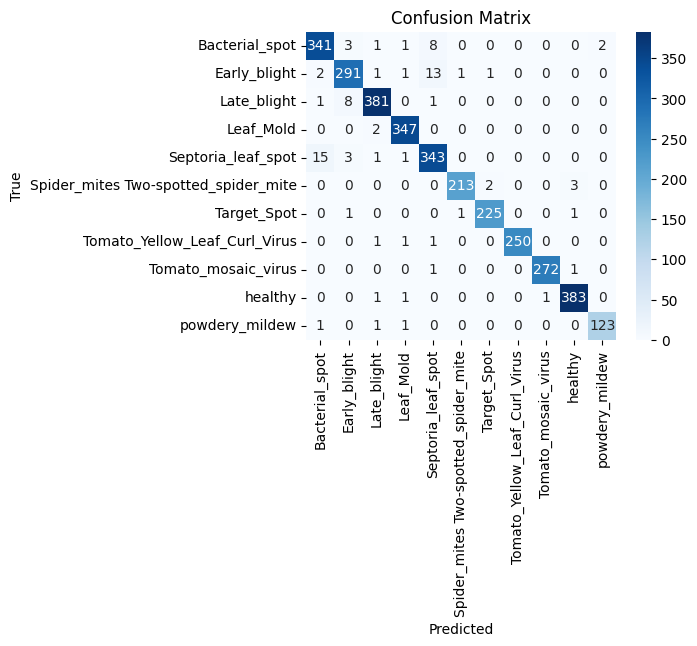

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [17]:
overall_accuracy = accuracy_score(y_true, y_pred)
overall_precision = precision_score(y_true, y_pred, average='macro')  # Weighted average for class imbalance
overall_recall = recall_score(y_true, y_pred, average='macro')
overall_f1 = f1_score(y_true, y_pred, average='macro')

print(f"Overall Accuracy: {overall_accuracy:.4f}")
print(f"Overall Precision: {overall_precision:.4f}")
print(f"Overall Recall: {overall_recall:.4f}")
print(f"Overall F1-Score: {overall_f1:.4f}")

Overall Accuracy: 0.9739
Overall Precision: 0.9764
Overall Recall: 0.9748
Overall F1-Score: 0.9756


In [18]:
specificity = []

for i in range(len(cm)):
    tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
    fp = cm[:, i].sum() - cm[i, i]
    specificity.append(tn / (tn + fp))

overall_specificity = np.mean(specificity)  # Average specificity

print(f"Overall Specificity: {overall_specificity:.4f}")

Overall Specificity: 0.9973


In [19]:
# Sensitivity (Recall)
def calculate_specificity(cm, CLASS_NAMES):

    # Specificity
    specificity = []
    for i in range(len(cm)):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        specificity.append(tn / (tn + fp))

    print("\nPer-Class Specificity:")
    for idx, class_name in enumerate(CLASS_NAMES):
        print(f"Class {class_name}: {specificity[idx]:.4f}")

    return specificity

In [20]:
# print("\n--- Train Data Metrics ---")
specificity = calculate_specificity(cm, CLASS_NAMES)


Per-Class Specificity:
Class Late_blight: 0.9934
Class Tomato_Yellow_Leaf_Curl_Virus: 0.9949
Class Septoria_leaf_spot: 0.9972
Class Early_blight: 0.9979
Class Spider_mites Two-spotted_spider_mite: 0.9917
Class powdery_mildew: 0.9993
Class healthy: 0.9990
Class Bacterial_spot: 1.0000
Class Target_Spot: 0.9997
Class Tomato_mosaic_virus: 0.9983
Class Leaf_Mold: 0.9994


In [21]:
class_accuracies = cm.diagonal() / cm.sum(axis=1)

# Create a DataFrame for the class-wise accuracies
class_accuracy_df = pd.DataFrame({
    "Class": list(test_generator.class_indices.keys()),
    "Accuracy": class_accuracies
})

print("\nClass-wise Accuracies:")
print(class_accuracy_df.to_string(index=False))


Class-wise Accuracies:
                               Class  Accuracy
                      Bacterial_spot  0.957865
                        Early_blight  0.938710
                         Late_blight  0.974425
                           Leaf_Mold  0.994269
                  Septoria_leaf_spot  0.944904
Spider_mites Two-spotted_spider_mite  0.977064
                         Target_Spot  0.986842
       Tomato_Yellow_Leaf_Curl_Virus  0.988142
                 Tomato_mosaic_virus  0.992701
                             healthy  0.992228
                      powdery_mildew  0.976190


### Run prediction on a sample image

In [22]:
import random
from tensorflow.keras.preprocessing import image

random_indices = random.sample(range(len(y_true)), 15)

class_names = list(test_generator.class_indices.keys())

# Iterate through the random indices and display actual and predicted results
for idx in random_indices:
    actual_class = class_names[y_true[idx]]
    predicted_class = class_names[y_pred[idx]]
    print(f"Actual: {actual_class} ,  Predicted: {predicted_class}")

Actual: Tomato_mosaic_virus ,  Predicted: Tomato_mosaic_virus
Actual: Early_blight ,  Predicted: Early_blight
Actual: Bacterial_spot ,  Predicted: Bacterial_spot
Actual: Bacterial_spot ,  Predicted: Bacterial_spot
Actual: Septoria_leaf_spot ,  Predicted: Septoria_leaf_spot
Actual: Bacterial_spot ,  Predicted: Bacterial_spot
Actual: Tomato_mosaic_virus ,  Predicted: Tomato_mosaic_virus
Actual: Leaf_Mold ,  Predicted: Leaf_Mold
Actual: Septoria_leaf_spot ,  Predicted: Septoria_leaf_spot
Actual: Septoria_leaf_spot ,  Predicted: Septoria_leaf_spot
Actual: Late_blight ,  Predicted: Late_blight
Actual: Late_blight ,  Predicted: Late_blight
Actual: healthy ,  Predicted: healthy
Actual: healthy ,  Predicted: healthy
Actual: Bacterial_spot ,  Predicted: Bacterial_spot
